In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import *

# Handling text 2 exercise
[Handling text exercisses ADApted drom ADA 2018 final exam]

The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [2]:
# your code goes here
import codecs, os
with open(os.path.join("./data/","all_scripts.txt"),encoding="utf8") as f:
    scripts = f.read()
    
scripts: list[str] = scripts.split("\n")
print("\n".join(scripts[:10]))
# scripts = " ".join(scripts.split())
# print(scripts[:300])

>> Series 01 Episode 01 – Pilot Episode
> A corridor at a sperm bank.
Sheldon: So if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits. If it’s unobserved it will, however, if it’s observed after it’s left the plane but before it hits its target, it will not have gone through both slits.
Leonard: Agreed, what’s your point?
Sheldon: There’s no point, I just think it’s a good idea for a tee-shirt.
Leonard: Excuse me?
Receptionist: Hang on.
Leonard: One across is Aegean, eight down is Nabakov, twenty-six across is MCM, fourteen down is… move your finger… phylum, which makes fourteen across Port-au-Prince. See, Papa Doc’s capital idea, that’s Port-au-Prince. Haiti.
Receptionist: Can I help you?
Leonard: Yes. Um, is this the High IQ sperm bank?


In [3]:
scripts_data: list[dict] = []
scenes_season_data: list[dict] = []

curr_season = 0
curr_episode = 0
curr_scene = 0

count_scene = 0
for line in scripts:
    if line.startswith(">>"): 
        curr_episode += 1
        curr_scene = 0
        
        splited = line.split()
        season = int(splited[2]) # Position of the season number
        
        if season != curr_season:
            scenes_season_data += [{
                "season": curr_season,
                "count_scene": count_scene,
            }]
            count_scene = 0
            curr_season = season
        continue
    elif line.startswith(">"):
        curr_scene += 1
        count_scene += 1
        continue
    
    aux = line.find(":")
    name = line[:aux]
    dialoge = line[aux+1:]
    
    scripts_data += [{
        "name": name,
        "season": curr_season,
        "episode": curr_episode,
        "scene": curr_scene,
        "dialoge": dialoge,
    }]
scenes_season_data += [{
    "season": curr_season,
    "count_scene": count_scene,
}]
    
pd_seasons = pd.DataFrame(scenes_season_data[1:])
pd_scripts = pd.DataFrame(scripts_data)
pd_scripts.head(10)


,name,season,episode,scene,dialoge
0,Sheldon,1,1,1,So if a photon is directed through a plane wi...
1,Leonard,1,1,1,"Agreed, what’s your point?"
2,Sheldon,1,1,1,"There’s no point, I just think it’s a good id..."
3,Leonard,1,1,1,Excuse me?
4,Receptionist,1,1,1,Hang on.
5,Leonard,1,1,1,"One across is Aegean, eight down is Nabakov, ..."
6,Receptionist,1,1,1,Can I help you?
7,Leonard,1,1,1,"Yes. Um, is this the High IQ sperm bank?"
8,Receptionist,1,1,1,"If you have to ask, maybe you shouldn’t be here."
9,Sheldon,1,1,1,I think this is the place.


In [4]:
pd_seasons

,season,count_scene
0,1,160
1,2,231
2,3,236
3,4,279
4,5,254
5,6,304
6,7,332
7,8,327
8,9,337
9,10,346


**Q2**. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

In [5]:
# your code goes here
pd_recurrent = pd_scripts.groupby("name").filter(lambda x: len(x["episode"].unique()) > 1)
pd_recurrent = pd_recurrent.groupby("name").filter(lambda x: len(x) > 90)

recurrent_characters = pd_recurrent["name"].unique()
print(f"We have {len(recurrent_characters)} recurrent characters: {recurrent_characters}")

We have 20 recurrent characters: ['Sheldon' 'Leonard' 'Penny' 'Howard' 'Raj' 'Man' 'Mrs Cooper' 'Leslie'
 'Kripke' 'Beverley' 'Stuart' 'Bernadette' 'Wil' 'Mrs Wolowitz' 'Zack'
 'Amy' 'Priya' 'Arthur' 'Bert' 'Emily']


In [6]:
pd_recurrent = pd_recurrent[pd_recurrent["name"] != "Man"]

recurrent_characters = pd_recurrent["name"].unique()
recurrent_characters

array(['Sheldon', 'Leonard', 'Penny', 'Howard', 'Raj', 'Mrs Cooper',
       'Leslie', 'Kripke', 'Beverley', 'Stuart', 'Bernadette', 'Wil',
       'Mrs Wolowitz', 'Zack', 'Amy', 'Priya', 'Arthur', 'Bert', 'Emily'],
      dtype=object)

## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [7]:
# your code goes here
def remove_chars(text):
    for char in EXCLUDE_CHARS:
        text = text.replace(char, " ")
    return text.lower()
        
pd_recurrent["dialoge"] = pd_recurrent["dialoge"].apply(remove_chars)
pd_recurrent["dialoge"]

0         so if a photon is directed through a plane wi...
1                               agreed  what s your point 
2         there s no point  i just think it s a good id...
3                                               excuse me 
5         one across is aegean  eight down is nabakov  ...
                               ...                        
51284     uh  breakfast yes  lunch no  i did have a cou...
51286                           how thoughtful  thank you 
51288     and i with you  question  are you seeking a r...
51290     well  that would raise a number of problems  ...
51291      knock  knock  knock  amy   knock  knock  kno...
Name: dialoge, Length: 48346, dtype: object

**Q4**. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

In [11]:
# your code goes here
from collections import  Counter
# term_frequency = Counter()

# for idx, row in pd_recurrent.iterrows():
#     for token in row["dialoge"].split():
#         term_frequency[token] += 1

term_frequency = Counter(" ".join(pd_recurrent["dialoge"]).split())

In [14]:
pd_term_frequency = pd.DataFrame(term_frequency.items(), columns=["token", "frequency"])

pd_term_frequency                 

,token,frequency
0,so,3187
1,if,2490
2,a,13518
3,photon,4
4,is,5444
...,...,...
21097,skyped,1
21098,corresponded,1
21099,nickels,1
21100,highlighted,1


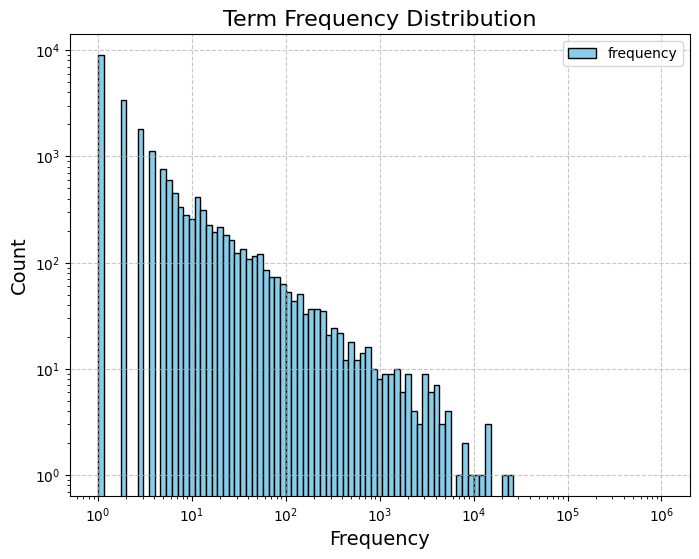

In [25]:
pd_term_frequency.plot.hist(loglog=True, color='skyblue', edgecolor='black', figsize=(8, 6),
                            bins=np.logspace(0, 6, 100), title="Frequency histogram (loglog scale)")

plt.title("Term Frequency Distribution", fontsize=16)
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
# plt.xscale("log")

Given that term frequencies follow the Zipf's law, the frequency of terms follow a 1/x distribution very similar to power law, there fore a log log scale should be applied

### Part 2: Talkativity
**Q5**. For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

In [32]:
# your code goes here
pd_recurrent["n_words"] = pd_recurrent["dialoge"].apply(lambda x: len(x.split()))

talkativity = pd_recurrent.groupby("name")[["n_words"]].sum()
talkativity.sort_values("n_words", ascending=False) 

,n_words
name,
Sheldon,185388
Leonard,102496
Penny,79270
Howard,69505
Raj,60099
Amy,39933
Bernadette,27726
Stuart,7955
Mrs Cooper,3389


Our lovely Sheldon is the one that yaps yaps the most

## Task D: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons.

In [33]:
# your code goes here
# We have 10 seasons
pd_recurrent["said_by_sheldon"] = pd_recurrent["name"] == "Sheldon"

pd_train = pd_recurrent[pd_recurrent["season"] <= 8]
pd_test = pd_recurrent[pd_recurrent["season"] > 8]

X_train = pd_train.drop(columns=["said_by_sheldon"])
y_train = pd_train[["said_by_sheldon"]]

X_test= pd_test.drop(columns=["said_by_sheldon"])
y_test= pd_test[["said_by_sheldon"]]

In [35]:
pd_recurrent.head()

,name,season,episode,scene,dialoge,n_words,said_by_sheldon
0,Sheldon,1,1,1,so if a photon is directed through a plane wi...,57,True
1,Leonard,1,1,1,agreed what s your point,5,False
2,Sheldon,1,1,1,there s no point i just think it s a good id...,16,True
3,Leonard,1,1,1,excuse me,2,False
5,Leonard,1,1,1,one across is aegean eight down is nabakov ...,39,False


In [37]:
print(f"We have {len(X_train):_} train sentences and {len(X_test):_} test sentences")

We have 38_177 train sentences and 10_169 test sentences


**Q7**. Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

In [42]:
# your code goes here
sheldon_words = " ".join(pd_train[pd_train["name"] == "Sheldon"]["dialoge"]).split()
other_words = " ".join(pd_train[pd_train["name"] != "Sheldon"]["dialoge"]).split()

sheldon_words = set(sheldon_words)
other_words = set(other_words)

unique_words = list(sheldon_words - other_words)
len(unique_words)

5269

In [48]:
N = len(pd_test)
correct = 0
unique_words = set(unique_words)
for idx, row in pd_test.iterrows():
    is_sheldon = len(set(row["dialoge"]) & unique_words) > 0
    if is_sheldon == row["said_by_sheldon"]:
        correct += 1

print(f"Acurracy of {correct/N: 0.4%}")

Acurracy of  78.0018%


In [49]:
unique_words = set(unique_words)
N = len(pd_test)

def contain_sheldon(text: str) -> bool:
    return len(set(text) & unique_words) > 0

pred = pd_test["dialoge"].apply(contain_sheldon)
accuracy = np.sum(pred == pd_test["said_by_sheldon"])
print(f"Acurracy of {accuracy/N: 0.4%}")


Acurracy of  78.0018%
